In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns

import simplejson
import json
import math
save = False

# 1. Data Preprocessing

In [2]:
%%time
### Get stock related data ###

if not save:
    stock_info_list = pd.read_feather('stock_list.ftr')
else:
    stock_info_list = pd.read_csv('raw/stock_list.csv', parse_dates=['list_date', 'setup_date'])
    stock_info_list.ts_code = stock_info_list.ts_code.apply(lambda x: x[:6])
    stock_info_list = stock_info_list.query('market == "主板" or market == "中小板"')  # Focus only on mainboard and sme, cover all three-level sectors
    stock_info_list = stock_info_list.query('list_date < "2020-01-01"').reset_index(drop=True)  # Remove those got listed too late (171 of them)
    stock_info_list.to_feather('stock_list.ftr')

if not save:
    trade_cal = pd.read_feather('trade_cal.ftr')
else:
    trade_cal = pd.read_csv('raw/trade_cal.csv', parse_dates=['cal_date'])
    trade_cal.to_feather('trade_cal.ftr')

if not save:
    stock_daily = pd.read_feather('stock_daily.ftr')
    stock_daily_log = pd.read_pickle('stock_daily_log.pkl')
else:
    stock_daily = pd.read_feather('raw/stock_price_post_adjusted.ftr')
    stock_daily.ts_code = stock_daily.ts_code.apply(lambda x: x[:6])
    stock_daily = stock_daily[['ts_code', 'trade_date', 'close', 'vol']].query('"2010-12-25" <= trade_date <= "2020-12-31"')
    stock_daily = stock_daily.merge(stock_info_list['ts_code'])
    stock_daily_log = stock_daily.pivot_table(values=['close', 'vol'], index='trade_date', columns='ts_code')
    stock_daily_log = np.log(stock_daily_log)
    stock_daily_log = stock_daily_log - stock_daily_log.shift(1)
    
    stock_daily = stock_daily.query('"2011-01-01" <= trade_date <= "2020-12-31"').reset_index(drop=True)
    stock_daily.to_feather('stock_daily.ftr')
    stock_daily_log = stock_daily_log.loc['2011-01-01':]
    stock_daily_log.to_pickle('stock_daily_log.pkl')

CPU times: user 281 ms, sys: 226 ms, total: 507 ms
Wall time: 308 ms


In [3]:
%%time
### Get concept and index related data ###

if not save:
    concept_list = pd.read_feather('concept_list.ftr')
    concept_daily = pd.read_feather('concept_daily.ftr')
    concept_daily_log = pd.read_pickle('concept_daily_log.pkl')
else:
    concept_list = pd.read_csv('raw/concept_member_list.csv').drop('name', axis=1).merge(pd.read_csv('raw/concept_list.csv').drop('list_date', axis=1))
    concept_list.columns = ['concept_code', 'ts_code', 'name']
    concept_list.ts_code = concept_list.ts_code.apply(lambda x: x[:6])
    concept_list = concept_list.merge(stock_info_list['ts_code'])
    concept_list.to_feather('concept_list.ftr')
    
    concept_daily = pd.read_csv('raw/concept_daily_list.csv', parse_dates=['trade_date'])[['ts_code', 'trade_date', 'close']].query('"2010-12-25" <= trade_date <= "2020-12-31"')
    concept_daily.columns = ['concept_id', 'trade_date', 'close']
    concept_daily_log = concept_daily.pivot_table(values=['close'], index='trade_date', columns='concept_id')
    concept_daily_log = np.log(concept_daily_log)
    concept_daily_log = concept_daily_log - concept_daily_log.shift(1)
    
    concept_daily = concept_daily.query('"2011-01-01" <= trade_date <= "2020-12-31"').reset_index(drop=True)
    concept_daily.to_feather('concept_daily.ftr')
    concept_daily_log = concept_daily_log.close.loc['2011-01-01':]
    concept_daily_log.to_pickle('concept_daily_log.pkl')

    
if not save:
    index_daily = pd.read_feather('index_daily.ftr')
    index_daily_log = pd.read_pickle('index_daily_log.pkl')
else:
    index_daily = pd.read_csv('raw/index_daily_list.csv', parse_dates=['trade_date'])[['ts_code', 'trade_date', 'close']].query('"2010-12-25" <= trade_date <= "2020-12-31"')
    index_daily.columns = ['in_code', 'trade_date', 'close']
    missing_index_daily = [index_daily]
    for missing_index in ['000988', '000994', '000995']:
        missing_index_df = pd.read_json(f'raw/{missing_index}.json', convert_dates='tradedate')
        missing_index_df['in_code'] = f'{missing_index}.SH'
        missing_index_df['trade_date'] = pd.to_datetime(missing_index_df.tradedate)
        missing_index_df.columns = ['1', '2', 'close', '3', '4', 'in_code', 'trade_date']
        missing_index_daily.append(missing_index_df[['in_code', 'trade_date', 'close']])
    index_daily = pd.concat(missing_index_daily).query('"2010-12-25" <= trade_date <= "2020-12-31"')
    index_daily = index_daily.drop_duplicates(['in_code', 'trade_date'])
    index_daily_log = index_daily.pivot_table(values=['close'], index='trade_date', columns='in_code')
    index_daily_log = np.log(index_daily_log)
    index_daily_log = index_daily_log - index_daily_log.shift(1)
    
    index_daily = index_daily.query('"2011-01-01" <= trade_date <= "2020-12-31"').reset_index(drop=True)
    index_daily.to_feather('index_daily.ftr')
    index_daily_log = index_daily_log.close.loc['2011-01-01':]
    index_daily_log.to_pickle('index_daily_log.pkl')

CPU times: user 24.7 ms, sys: 13.6 ms, total: 38.3 ms
Wall time: 29.5 ms


In [4]:
%%time
### Get industry and industry-index related data ###

if not save:
    industry_list = pd.read_feather('industry_list.ftr')
else:
    industry_list = pd.read_csv('raw/industry_member_list.csv').rename(columns={'con_code': 'ts_code'})
    industry_list.ts_code = industry_list.ts_code.apply(lambda x: x[:6])
    industry_list = industry_list.merge(stock_info_list[['ts_code']])
    industry_list = industry_list.merge(pd.read_csv('raw/industry_list.csv'))
    industry_list = industry_list[['industry_code', 'industry_name', 'level', 'ts_code']]
    industry_list.to_feather('industry_list.ftr')

if not save:
    index_industry_list = pd.read_feather('index_industry_list.ftr')
else:
    index_industry_list = pd.read_csv('raw/index_industry_list.csv')[['ts_code', 'name', 'industry_code']]
    index_industry_list.columns = ['in_code', 'name_c', 'industry_code']
    index_name_input = pd.Series({
        '000986.SH': 'Energy',
        '000987.SH': 'Materials',
        '000988.SH': 'Industrials',
        '000989.SH': 'Consumer Discretionary',
        '000990.SH': 'Consumer Staples',
        '000991.SH': 'HealthCare',
        '000992.SH': 'Financials',
        '000993.SH': 'IT',
        '000994.SH': 'Telecom',
        '000995.SH': 'Utilities',
    }, name='name')
    index_industry_list = index_industry_list.merge(index_name_input, left_on='in_code', right_index=True)
    index_industry_list.to_feather('index_industry_list.ftr')

CPU times: user 5.22 ms, sys: 2.59 ms, total: 7.82 ms
Wall time: 5.98 ms


# 2. Correlation networks

In [5]:
%%time

corr_all_years = []

if not save:
    corr_all_years = pd.read_pickle('corr_all_years.pkl')
if save:
    # Takes 15 mins to run
    for year in range(11, 21):
        trade_days = int(trade_cal.query(f'"20{year}-01-01" <= cal_date <= "20{year}-12-31"')['is_open'].sum() * 0.8)
        asset_prices = pd.concat([index_daily_log.loc[f'20{year}-01-01':f'20{year}-12-31']['000001.SH'], stock_daily_log.close.loc[f'20{year}-01-01':f'20{year}-12-31']], axis=1)
        corr_all_years.append(asset_prices.corr(method='spearman', min_periods=trade_days))
    corr_all_years = pd.concat(corr_all_years, axis=1, keys=[f'20{year}' for year in range(11,21)])
    corr_all_years.round(4).to_pickle('corr_all_years.pkl')
    

corr_all_years_no_index = corr_all_years.drop(columns=[(str(year), '000001.SH') for year in range(2011, 2021)]).iloc[1:]
corr_all_years_index = corr_all_years.drop(columns=[(str(year), '000001.SH') for year in range(2011, 2021)]).iloc[0]
corr_all_years

CPU times: user 464 ms, sys: 689 ms, total: 1.15 s
Wall time: 1.15 s


2011                                                        \
          000001.SH  000001 000002  000004 000005  000006  000007  000008   
000001.SH    1.0000  0.6906  0.649  0.5275    NaN  0.6898  0.5537  0.5847   
000001       0.6906  1.0000  0.541  0.2914    NaN  0.5220  0.3091  0.3280   
000002       0.6490  0.5410  1.000  0.2430    NaN  0.6252  0.3230  0.2995   
000004       0.5275  0.2914  0.243  1.0000    NaN  0.4042  0.4124  0.4896   
000005          NaN     NaN    NaN     NaN    NaN     NaN     NaN     NaN   
...             ...     ...    ...     ...    ...     ...     ...     ...   
603995          NaN     NaN    NaN     NaN    NaN     NaN     NaN     NaN   
603996          NaN     NaN    NaN     NaN    NaN     NaN     NaN     NaN   
603997          NaN     NaN    NaN     NaN    NaN     NaN     NaN     NaN   
603998          NaN     NaN    NaN     NaN    NaN     NaN     NaN     NaN   
603999          NaN     NaN    NaN     NaN    NaN     NaN     NaN     NaN   

                          ...    2020                                          \
           000009 000010  ...  603989  603990  603991  603992  603993  603995   
000001.SH  0.5255    NaN  ...  0.5408  0.3919  0.2907  0.3850  0.6418  0.4590   
000001     0.3173    NaN  ...  0.2093  0.1529  0.0066  0.2300  0.3626  0.2339   
000002     0.2896    NaN  ...  0.1051  0.1768 -0.0538  0.1264  0.4227  0.1590   
000004     0.4272    NaN  ...  0.4459  0.3328  0.2182  0.3006  0.2414  0.2611   
000005        NaN    NaN  ...  0.3480  0.2608  0.2792  0.3303  0.3690  0.4244   
...           ...    ...  ...     ...     ...     ...     ...     ...     ...   
603995        NaN    NaN  ...  0.2452  0.1673  0.1871  0.3029  0.3565  1.0000   
603996        NaN    NaN  ...  0.1017  0.1511  0.1729  0.1550  0.1113  0.1896   
603997        NaN    NaN  ...  0.3157  0.2595  0.1559  0.1953  0.4269  0.2176   
603998        NaN    NaN  ...  0.3469  0.2340  0.2810  0.3211  0.3405  0.3566   
603999        NaN    NaN  ...  0.4092  0.3371  0.2796  0.4316  0.4339  0.3475   

                                           
           603996  603997  603998  603999  
000001.SH  0.2322  0.4868  0.5934  0.6498  
000001     0.1034  0.2338  0.2760  0.2984  
000002     0.1202  0.2015  0.2157  0.2083  
000004     0.2525  0.2763  0.2897  0.3997  
000005     0.2533  0.3706  0.4805  0.5590  
...           ...     ...     ...     ...  
603995     0.1896  0.2176  0.3566  0.3475  
603996     1.0000  0.0886  0.2028  0.2578  
603997     0.0886  1.0000  0.3152  0.3736  
603998     0.2028  0.3152  1.0000  0.4858  
603999     0.2578  0.3736  0.4858  1.0000  

[2876 rows x 28760 columns]

In [6]:
def get_index_corr_distribution(year='2011'):
    corr_out = pd.cut(corr_all_years_index[str(year)], bins=[i/100 for i in range(-100, 101, 5)], precision=2, right=True, include_lowest=True).value_counts()
    return [corr_out[i/100] for i in range(-100, 101, 5)]

def get_stock_corr_distribution(query_code='000001', year='2011'):
    corr_out = pd.cut(corr_all_years_no_index[str(year)].loc[query_code], bins=[i/100 for i in range(-100, 101, 5)], precision=2, right=True, include_lowest=True).value_counts()
    return [corr_out[i/100] for i in range(-100, 101, 5)]

query_codes=['000895', '002567', '603363', '002840', '002100', '000538']
year='2015'
threshold = 0.68

print(get_index_corr_distribution(year))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 6, 36, 70, 159, 295, 369, 296, 184, 81, 21, 0, 0, 0]


In [12]:
corr_filter = pd.eval('|'.join([f'(corr_all_years_no_index["{str(year)}"]["{query_code}"] > {threshold})' for query_code in query_codes]))
corr_filter = corr_all_years_no_index[year].loc[corr_filter]
corr_filter = corr_filter.filter(items=corr_filter.index)
corr_filter

,000423,000538,000625,000869,000895,002008,002100,002304,002521,600085,...,600486,600535,600660,600738,600809,600811,600887,601607,603077,603167
000423,1.0000,0.7467,0.6741,0.6578,0.6916,0.5608,0.5443,0.6816,0.6118,0.7332,...,0.6319,0.7209,0.7266,0.5350,0.7006,0.6740,0.6375,0.6866,0.5194,0.5258
000538,0.7467,1.0000,0.6116,0.6042,0.6893,0.4620,0.4764,0.6680,0.5678,0.7147,...,0.5292,0.7094,0.6979,0.4518,0.6564,0.6279,0.6196,0.6734,0.5075,0.4831
000625,0.6741,0.6116,1.0000,0.6859,0.6962,0.5097,0.4432,0.6256,0.4457,0.6076,...,0.4673,0.7107,0.7108,0.4110,0.6697,NaN,0.6840,0.6467,NaN,0.5352
000869,0.6578,0.6042,0.6859,1.0000,0.7072,0.5286,0.4850,0.6427,0.5042,0.5697,...,0.5193,0.6349,0.6830,0.4755,0.7245,0.6692,0.6559,0.6383,0.4686,0.5570
000895,0.6916,0.6893,0.6962,0.7072,1.0000,0.4858,0.4831,0.7174,0.5134,0.6219,...,0.5294,0.6450,0.7085,0.4529,0.7128,0.7128,0.6875,0.7117,0.5267,0.5176
002008,0.5608,0.4620,0.5097,0.5286,0.4858,1.0000,0.6820,0.3922,0.7008,0.5476,...,0.6503,0.5032,0.5205,0.6345,0.5796,0.6599,0.4941,0.5737,0.6091,0.6865
002100,0.5443,0.4764,0.4432,0.4850,0.4831,0.6820,1.0000,0.4572,0.6894,0.5366,...,0.6983,0.5151,0.5505,0.6906,0.5556,0.6124,0.4604,0.5394,0.7039,0.6875
002304,0.6816,0.6680,0.6256,0.6427,0.7174,0.3922,0.4572,1.0000,0.4635,0.5933,...,0.4739,0.6039,0.6811,0.3659,0.6868,0.5838,0.6278,0.5611,0.4879,0.4487
002521,0.6118,0.5678,0.4457,0.5042,0.5134,0.7008,0.6894,0.4635,1.0000,0.6007,...,0.7074,0.5469,0.5543,0.6782,0.5988,0.6273,0.4555,0.5903,0.6388,0.6895
600085,0.7332,0.7147,0.6076,0.5697,0.6219,0.5476,0.5366,0.5933,0.6007,1.0000,...,0.6005,0.6595,0.6573,0.5153,0.6175,0.6035,0.5339,0.6396,0.4624,0.5452


In [24]:
%%time

G = nx.from_pandas_adjacency(corr_filter, create_using=nx.Graph)
G.remove_edges_from([(u, v) for (u, v, wt) in G.edges.data('weight') if math.isnan(wt) or wt < threshold or u == v])
# G.remove_nodes_from(list(nx.isolates(G)))
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 23
Number of edges: 64
Average degree:   5.5652
CPU times: user 4.07 ms, sys: 313 µs, total: 4.39 ms
Wall time: 4.17 ms


In [25]:
sorted(nx.connected_components(BG), key=len, reverse=True)

[{'000423',
  '000538',
  '000625',
  '000869',
  '000895',
  '002008',
  '002100',
  '002304',
  '002521',
  '600085',
  '600143',
  '600199',
  '600327',
  '600486',
  '600535',
  '600660',
  '600738',
  '600809',
  '600811',
  '600887',
  '601607',
  '603077',
  '603167'}]

In [21]:
%%time

BG = G.copy()
BG.add_edges_from([(u, v, {'weight': 1-wt}) for (u, v, wt) in BG.edges.data('weight')])
print(nx.info(BG))

Name: 
Type: Graph
Number of nodes: 23
Number of edges: 64
Average degree:   5.5652
CPU times: user 684 µs, sys: 99 µs, total: 783 µs
Wall time: 761 µs


In [22]:
betweenness_centrality = nx.algorithms.centrality.betweenness_centrality(BG, endpoints=True, weight='weight')
betweenness_centrality

{'000423': 0.18972332015810275,
 '000538': 0.08695652173913043,
 '000625': 0.08695652173913043,
 '000869': 0.0909090909090909,
 '000895': 0.3201581027667984,
 '002008': 0.08695652173913043,
 '002100': 0.09881422924901186,
 '002304': 0.08695652173913043,
 '002521': 0.08695652173913043,
 '600085': 0.08695652173913043,
 '600143': 0.08695652173913043,
 '600199': 0.26482213438735175,
 '600327': 0.3992094861660079,
 '600486': 0.08695652173913043,
 '600535': 0.10276679841897232,
 '600660': 0.09486166007905138,
 '600738': 0.08695652173913043,
 '600809': 0.26482213438735175,
 '600811': 0.3557312252964427,
 '600887': 0.08695652173913043,
 '601607': 0.08695652173913043,
 '603077': 0.08695652173913043,
 '603167': 0.20553359683794464}

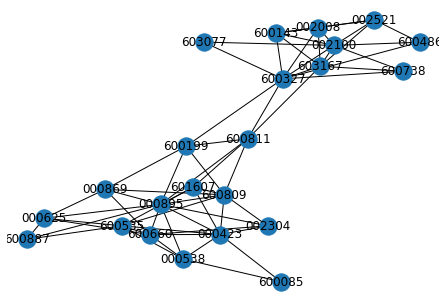

In [23]:
nx.draw(BG, with_labels=True)

# Backup

In [51]:
# start_date = '2020-01-01'
# end_date = '2020-06-30'
# query_codes = ['000652', '000538']
start_date = '2015-01-01'
end_date = '2015-12-31'
query_codes = ['000895', '002567', '603363', '002840', '002100', '000538']
features = ['close', 'vol']

display(stock_info_list.merge(pd.Series(query_codes, name='ts_code')))

def corr_community_detection(query_codes=['000652', '000538'], method='pearson', start_date='2020-01-01', end_date='2020-06-30'):
    # filter stock price by timeframe
    stock_price = stock_daily_log.loc[start_date:end_date]
    # filter stock price by 0.8*total trade days in the timeframe
    trade_days = trade_cal.query('@start_date <= cal_date <= @end_date')['is_open'].sum() * 0.8
    trade_days_filter = [(~pd.isna(stock_price.close[column])).sum() > trade_days*0.8 for column in stock_price.close.columns] * 2
    stock_price = stock_price.transpose()[trade_days_filter].transpose()
    
    # find individual corrlation with other assets
    selected_corr = []
    for feature in features:
        selected_stocks = [stock_price[feature].corrwith(stock_price[feature][query_code], method=method, drop=True) for query_code in query_codes]
        selected_corr.append(pd.DataFrame(selected_stocks, index = query_codes).transpose())
    return pd.concat(selected_corr, axis=1, keys=features)

def corr_community_filter(corr, by='close', threshold=0.5):
    corr_filter = pd.eval('|'.join([f'(corr.{by}["{query_code}"].abs() >{threshold})' for query_code in query_codes]))
    corr_filter = corr[by][corr_filter]
    return list(corr_filter.index)

def corr_matrix(query_codes=['000652', '000538'], method='pearson', start_date='2020-01-01', end_date='2020-06-30'):
    # filter stock price by timeframe and query_codes
    stock_price = stock_daily_log.loc[start_date:end_date]
    stock_price = stock_price.transpose().loc[[(feature, index) for feature in features for index in community_filtered]].transpose()
    
    # find individual corrlation with other assets
    selected_corr = []
    for feature in features:
        selected_stocks = stock_price[feature].corr(method=method)
        selected_corr.append(selected_stocks)
    return pd.concat(selected_corr, axis=1, keys=features)

,ts_code,symbol,name,area,industry,market,list_date,exchange,chairman,manager,secretary,reg_capital,setup_date,province,city,website,email,employees
0,000538,538,云南白药,云南,中成药,主板,1993-12-15,SZSE,王明辉,董明,吴伟,127740.3317,1993-11-30,云南,昆明市,www.yunnanbaiyao.com.cn,wuwei@yunnanbaiyao.com.cn;ynby@yunnanbaiyao.co...,8124.0
1,000895,895,双汇发展,河南,食品,主板,1998-12-10,SZSE,万隆,马相杰,张立文,346466.1213,1998-10-15,河南,漯河市,www.shuanghui.net,0895@shuanghui.net,43245.0
2,002100,2100,天康生物,新疆,饲料,中小板,2006-12-26,SZSE,杨焰,成辉,郭运江,107514.9857,2000-12-28,新疆,乌鲁木齐市,www.tcsw.com.cn,tcsw@tcsw.com.cn;xj_gyj@163.com,2922.0
3,002567,2567,唐人神,湖南,饲料,中小板,2011-03-25,SZSE,陶一山,陶业,孙双胜,120601.7542,1992-09-11,湖南,株洲市,www.trsgroup.com.cn,TRS@tangrenshen.com.cn;sss@trsgroup.cn;sn-fz@t...,9754.0
4,002840,2840,华统股份,浙江,食品,中小板,2017-01-10,SZSE,朱俭军,朱俭军,朱婉珍,44747.9030,2001-08-08,浙江,金华市,www.huatongmeat.com,lysn600@163.com;zjwyh2017@126.com;zwz4789@163.com,2256.0
5,603363,603363,傲农生物,福建,饲料,主板,2017-09-26,SSE,吴有林,吴有林,侯浩峰,67401.6273,2011-04-26,福建,漳州市,www.aonong.com.cn,anzq@aonong.com.cn,4451.0


In [65]:
%%time

community = corr_community_detection(query_codes)

# community.to_pickle('default_community.pkl')
# pd.read_pickle('default_community.pkl')

community

CPU times: user 22.3 s, sys: 75 ms, total: 22.4 s
Wall time: 22.4 s


close                                                         vol  \
           000895    002567    603363    002840    002100    000538    000895   
ts_code                                                                         
000001   0.266850  0.139603  0.062994  0.233471  0.238403  0.338391  0.199816   
000002   0.227234  0.269562  0.094124  0.150087  0.201368  0.243419  0.384525   
000004   0.246898  0.244553  0.256539  0.151469  0.278646  0.193320 -0.083382   
000005   0.356857  0.415772  0.464838  0.305162  0.307698  0.229280  0.083330   
000006   0.298830  0.359063  0.250973  0.344554  0.280167  0.289002  0.038154   
...           ...       ...       ...       ...       ...       ...       ...   
603995   0.203779  0.247044  0.240855  0.320478  0.281826  0.216383 -0.016545   
603996   0.237152  0.221863  0.270128  0.131267  0.148986  0.273434  0.016926   
603997   0.131471  0.232726  0.349008  0.184385  0.245651  0.209298 -0.024292   
603998   0.139574  0.249888  0.269794  0.238783  0.284169  0.478255  0.009966   
603999   0.265677  0.323037  0.323592  0.269871  0.272196  0.263166  0.013817   

                                                           
           002567    603363    002840    002100    000538  
ts_code                                                    
000001   0.030234 -0.016672  0.038057  0.027260  0.298671  
000002   0.069767  0.006699 -0.140149  0.059667  0.185969  
000004   0.185669  0.086192  0.243672  0.049551  0.067797  
000005   0.270048  0.220084  0.131442  0.095581 -0.008175  
000006   0.043871  0.117992  0.117018  0.060056  0.063810  
...           ...       ...       ...       ...       ...  
603995   0.189857 -0.064635 -0.007958  0.150227  0.082093  
603996   0.135453  0.044346  0.124643  0.043194  0.052434  
603997   0.221868  0.031343  0.177666  0.105389  0.020980  
603998  -0.001341  0.003357 -0.009396 -0.106475  0.189828  
603999   0.061428  0.038784  0.129944 -0.016567  0.022494  

[2869 rows x 12 columns]

In [66]:
%%time 
community_filtered = corr_community_filter(community, threshold=0.60)
community_corr = corr_matrix(community_filtered)
community_corr

CPU times: user 127 ms, sys: 10.8 ms, total: 138 ms
Wall time: 139 ms


close                                                              \
ts_code    000538    000876    000895    002100    002124    002157    002234   
ts_code                                                                         
000538   1.000000  0.378465  0.265850  0.412451  0.373969  0.349367  0.352352   
000876   0.378465  1.000000  0.353312  0.703574  0.707421  0.740616  0.586441   
000895   0.265850  0.353312  1.000000  0.416948  0.404359  0.425213  0.296048   
002100   0.412451  0.703574  0.416948  1.000000  0.722031  0.758296  0.580767   
002124   0.373969  0.707421  0.404359  0.722031  1.000000  0.806899  0.718391   
002157   0.349367  0.740616  0.425213  0.758296  0.806899  1.000000  0.619574   
002234   0.352352  0.586441  0.296048  0.580767  0.718391  0.619574  1.000000   
002330   0.523799  0.533651  0.378300  0.611293  0.664641  0.613492  0.639746   
002385   0.314921  0.496793  0.212889  0.605865  0.505281  0.513823  0.513680   
002458   0.284446  0.677335  0.276481  0.576665  0.671947  0.607376  0.851256   
002548   0.387073  0.642601  0.300264  0.721615  0.783588  0.746465  0.719312   
002567   0.405389  0.685059  0.418066  0.772036  0.800556  0.827827  0.691352   
002714   0.368300  0.727953  0.355522  0.704327  0.602325  0.680560  0.443342   
002726   0.457397  0.583658  0.451233  0.662717  0.649639  0.734185  0.604025   
002746   0.348269  0.522231  0.234110  0.537480  0.652630  0.598991  0.844344   
002840   0.458738  0.379597  0.388774  0.434844  0.544667  0.571222  0.522743   
600073   0.460695  0.577568  0.503004  0.580654  0.625054  0.655579  0.608826   
600975   0.419093  0.622506  0.335797  0.675875  0.746813  0.739170  0.721341   
603363   0.395414  0.701599  0.375520  0.637125  0.738865  0.765004  0.618577   
603609   0.379583  0.579490  0.430333  0.670344  0.688461  0.691827  0.697786   

                                       ...       vol                      \
ts_code    002330    002385    002458  ...    002548    002567    002714   
ts_code                                ...                                 
000538   0.523799  0.314921  0.284446  ...  0.045553  0.012265  0.059601   
000876   0.533651  0.496793  0.677335  ...  0.537187  0.616243  0.570227   
000895   0.378300  0.212889  0.276481  ... -0.025411 -0.155182  0.268645   
002100   0.611293  0.605865  0.576665  ...  0.676418  0.774778  0.233750   
002124   0.664641  0.505281  0.671947  ...  0.589513  0.801515  0.196444   
002157   0.613492  0.513823  0.607376  ...  0.603691  0.804541  0.313103   
002234   0.639746  0.513680  0.851256  ...  0.597368  0.679250 -0.008086   
002330   1.000000  0.557200  0.616842  ...  0.574833  0.676761  0.060102   
002385   0.557200  1.000000  0.515778  ...  0.491969  0.547952 -0.039091   
002458   0.616842  0.515778  1.000000  ...  0.628799  0.733305  0.024102   
002548   0.655269  0.580496  0.689465  ...  1.000000  0.712067  0.116850   
002567   0.717676  0.592453  0.683429  ...  0.712067  1.000000  0.213368   
002714   0.396460  0.470580  0.471216  ...  0.116850  0.213368  1.000000   
002726   0.718877  0.509572  0.579407  ...  0.523395  0.658136  0.202239   
002746   0.661926  0.529169  0.782809  ...  0.624013  0.706563  0.082882   
002840   0.569554  0.379211  0.438744  ...  0.497505  0.591914  0.114969   
600073   0.632191  0.485459  0.594447  ...  0.294281  0.352744  0.260646   
600975   0.716702  0.600713  0.673170  ...  0.691120  0.778142  0.118987   
603363   0.641312  0.536966  0.628680  ...  0.604812  0.704650  0.182174   
603609   0.710337  0.607998  0.659627  ...  0.689314  0.773529  0.134277   

                                                                               
ts_code    002726    002746    002840    600073    600975    603363    603609  
ts_code                                                                        
000538   0.020728  0.058889  0.077702  0.017416 -0.105641 -0.012010  0.016105  
000876   0.480505  0.492990  0.351859  0.254533  0.537642  0.479676  0.500605  

# 2. Two-phase hierarchical clustering

In [70]:
def plot_corr(df,size=10):    
    # Plot the correlation matrix
    print(stock_info_list[['ts_code', 'name']].merge(pd.Series(df.columns)).set_index('ts_code').loc[df.columns])
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(df, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(cax)
    plt.xticks(range(len(df.columns)), df.columns, rotation=90);
    plt.yticks(range(len(df.columns)), df.columns);
    
def hierarchical_clustering(corr_df, by='close'):
    dist = sch.distance.pdist(corr_df[by].values)
    link = sch.linkage(dist, method='complete')
    index = sch.fcluster(link, dist.max()/2, 'distance')
    columns = corr_df[by].columns.tolist()
    columns = [columns[i] for i in np.argsort(index)]
    return corr_df[by].reindex(columns, axis=0).reindex(columns, axis=1)

def two_phase_hierarchical_clustering(corr_df, first_by='close', second_by='vol'):
    dist = sch.distance.pdist(corr_df[first_by].values)
    link = sch.linkage(dist, method='complete')
    index = sch.fcluster(link, dist.max(initial=0)/2, 'distance')
    columns = corr_df[first_by].columns.tolist()
    columns = [columns[i] for i in np.argsort(index)]
    corr_df_first_hc = corr_df[second_by].reindex(columns, axis=0).reindex(columns, axis=1)
    
    _, counts = np.unique(index, return_counts=True)
    i, j = 0, 0
    columns = []
    for count in counts:
        j += count
        sub_corr_df = corr_df_first_hc[corr_df_first_hc.columns.values[i:j]].loc[corr_df_first_hc.columns.values[i:j]]
        sub_corr_col = sub_corr_df.columns.tolist()
        if j-i > 1:
            dist = sch.distance.pdist(sub_corr_df.values)
            link = sch.linkage(dist, method='complete')
            index = sch.fcluster(link, dist.max(initial=0)/2, 'distance')
            sub_corr_col = [sub_corr_col[ind] for ind in np.argsort(index)]
        i = j
        columns.extend(sub_corr_col)
        
    corr_dfs = [(corr_df[feature].reindex(columns, axis=0).reindex(columns, axis=1)) for feature in features]
    return pd.concat(corr_dfs, axis=1, keys=features)

def combine_corr_matrix(top_right_df, bottom_left_df):
    for idx, col in enumerate(top_right_df.columns):
        bottom_left_df.loc[col][idx:] = top_right_df.loc[col][idx:]
    return bottom_left_df

def find_index_corr(columns, method='pearson', start_date='2020-01-01', end_date='2020-06-30'):
    # filter stock price by timeframe
    index_price = index_daily_log['000001.SH'].loc[start_date:end_date]
    stock_price = stock_daily_log.loc[start_date:end_date].close[columns]
    selected_stocks = stock_price.corrwith(index_price, method=method, drop=True)
    return list(selected_stocks.values)

In [67]:
corr_df = community_corr
link = sch.linkage(corr_df.close.values, method='complete')
index = sch.fcluster(link, dist.max()/2, 'distance')

In [68]:
link

array([[ 6.        ,  9.        ,  0.27860645,  2.        ],
       [10.        , 17.        ,  0.30459094,  2.        ],
       [ 4.        ,  5.        ,  0.33957994,  2.        ],
       [11.        , 22.        ,  0.3532545 ,  3.        ],
       [13.        , 19.        ,  0.36227104,  2.        ],
       [14.        , 20.        ,  0.41644172,  3.        ],
       [18.        , 21.        ,  0.46013502,  3.        ],
       [ 7.        , 24.        ,  0.48622921,  3.        ],
       [ 1.        ,  3.        ,  0.49872785,  2.        ],
       [23.        , 26.        ,  0.50856306,  6.        ],
       [16.        , 27.        ,  0.61187779,  4.        ],
       [12.        , 28.        ,  0.72694607,  3.        ],
       [29.        , 30.        ,  0.73519965, 10.        ],
       [25.        , 32.        ,  0.85320533, 13.        ],
       [ 8.        , 31.        ,  0.88604124,  4.        ],
       [ 0.        , 15.        ,  0.96468036,  2.        ],
       [ 2.        , 35.

         name
ts_code      
000538   云南白药
002840   华统股份
000895   双汇发展
603609   禾丰牧业
603363   傲农生物
002124   天邦股份
002157   正邦科技
002234   民和股份
002330    得利斯
002458   益生股份
002548    金新农
002567    唐人神
002726   龙大肉食
002746   仙坛股份
600975    新五丰
600073   上海梅林
002100   天康生物
000876    新希望
002714   牧原股份
002385    大北农
CPU times: user 117 ms, sys: 3.72 ms, total: 121 ms
Wall time: 119 ms


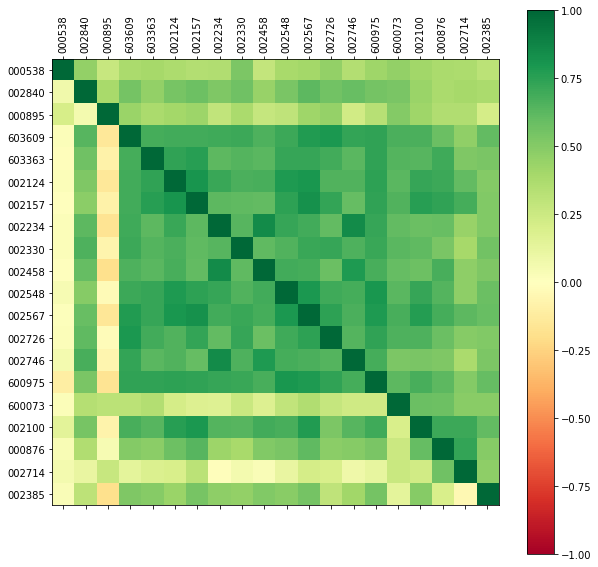

In [71]:
%%time

find_index_corr(community_corr.close.index)

# Pearson correlation matrix with no clustering
# Pearson correlation matrix for the close price between '2020-01-01' and '2020-06-30'
# Queried with ['000652', '000538'] = ['泰达股份', '云南白药'], and correlation threshold set as 0.6
# Resulted with 11 elements
# plot_corr(community_corr.close)

community_corr = two_phase_hierarchical_clustering(community_corr)
# Two phase hierarchical_clustering result, first base on close price (log return) then trading volume (log trading volume)
# With price as top-right, trading volume as bottom left
plot_corr(combine_corr_matrix(community_corr.close, community_corr.vol))

# 4. Correlation of different timeframes

In [13]:
start_date = '2020-01-01'
end_date = '2020-06-30'
# start_date = '2011-01-01'
# end_date = '2020-12-31'
query_code = '000652'
# query_code = '000538'
# query_code = '603301'

display(stock_info_list.query('ts_code == @query_code'))

def plot_corr(df,size=10):    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(df, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(cax)
    plt.gca().xaxis.tick_bottom()
    plt.xticks(range(len(df.columns)), df.columns, rotation=-90);
    plt.yticks(range(len(df.index)), df.index);

def rolling_corr_market(query_code='000652', start_date='2020-01-01', end_date='2020-06-30'):
    # find appropriate window size
    trade_days = trade_cal.query('@start_date <= cal_date <= @end_date')['is_open'].sum()
    window = int(max(1, trade_days/200))
    
    # filter stock price by timeframe
    index_price = index_daily_log[['000001.SH']].loc[start_date:end_date]
    stock_price = stock_daily_log.close[query_code].loc[start_date:end_date]
    index_stock_price = index_price.merge(stock_price, left_index=True, right_index=True)[::window]
    index_price = index_stock_price[index_stock_price.columns[0]]
    stock_price = index_stock_price[index_stock_price.columns[1]]
    
    # find individual corrlation with market
    pinus = {day: index_price.rolling(day, min_periods=1).corr(stock_price) for day in range(len(index_stock_price), 1, -1)}
    pinus = pd.DataFrame(pinus).round(4).replace([np.inf, -np.inf], np.nan)
    pinus.index = pinus.index.strftime('%Y-%m-%d')
    pinus = pinus.drop(index=pinus.index[0]).transpose() # round to 4dp and drop window size 1 because self correlation is always 1
    return pinus

def find_index_code(query_code='000652'):
    industry_code = industry_member_list.query('ts_code == @query_code and level == "L1"').industry_code.to_list()[0]
    return index_industry_list.query('industry_code == @industry_code').iloc[0]

,ts_code,symbol,name,area,industry,market,list_date,exchange,chairman,manager,secretary,reg_capital,setup_date,province,city,website,email,employees
210,000652,652,泰达股份,天津,批发业,主板,1996-11-28,SZSE,张旺,NaN,杨雪晶,147557.3852,1981-08-20,天津,天津市,www.tedastock.com,dm@tedastock.com,1274.0


In [14]:
%%time
pinus = rolling_corr_market(query_code, start_date, end_date)
pinus

CPU times: user 393 ms, sys: 13.1 ms, total: 406 ms
Wall time: 396 ms


trade_date,2020-01-03,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2020-06-15,2020-06-16,2020-06-17,2020-06-18,2020-06-19,2020-06-22,2020-06-23,2020-06-24,2020-06-29,2020-06-30
117,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0693,-0.0700,-0.0700,-0.0700
116,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0693,-0.0700,-0.0700,-0.0693
115,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0693,-0.0700,-0.0693,-0.0693
114,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0693,-0.0693,-0.0693,-0.0693
113,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0686,-0.0693,-0.0693,-0.0710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,-1.0,-0.5213,0.1801,0.7499,0.7730,0.9370,0.9154,0.8998,0.9248,0.9084,...,-0.4942,-0.6653,-0.6672,-0.7300,-0.8671,-0.8524,-0.5592,-0.3958,-0.6515,-0.4859
5,-1.0,-0.5213,0.1801,0.7499,0.9416,0.9476,0.9169,0.9469,0.8974,0.8302,...,-0.4033,-0.7027,-0.7969,-0.8479,-0.8632,-0.6415,-0.3942,-0.4384,-0.7848,-0.2352
4,-1.0,-0.5213,0.1801,0.9911,0.9499,0.9477,0.9917,0.8647,0.8345,0.8568,...,-0.4609,-0.8136,-0.9986,-0.8476,-0.5670,-0.4662,-0.4446,-0.6830,-0.7178,-0.1562
3,-1.0,-0.5213,0.9731,0.9922,0.9496,0.9996,0.9576,0.7624,0.9447,0.8174,...,-0.4241,-0.9993,-0.9997,-0.5440,-0.3845,-0.5107,-0.6828,-0.7748,-0.8642,-0.2442


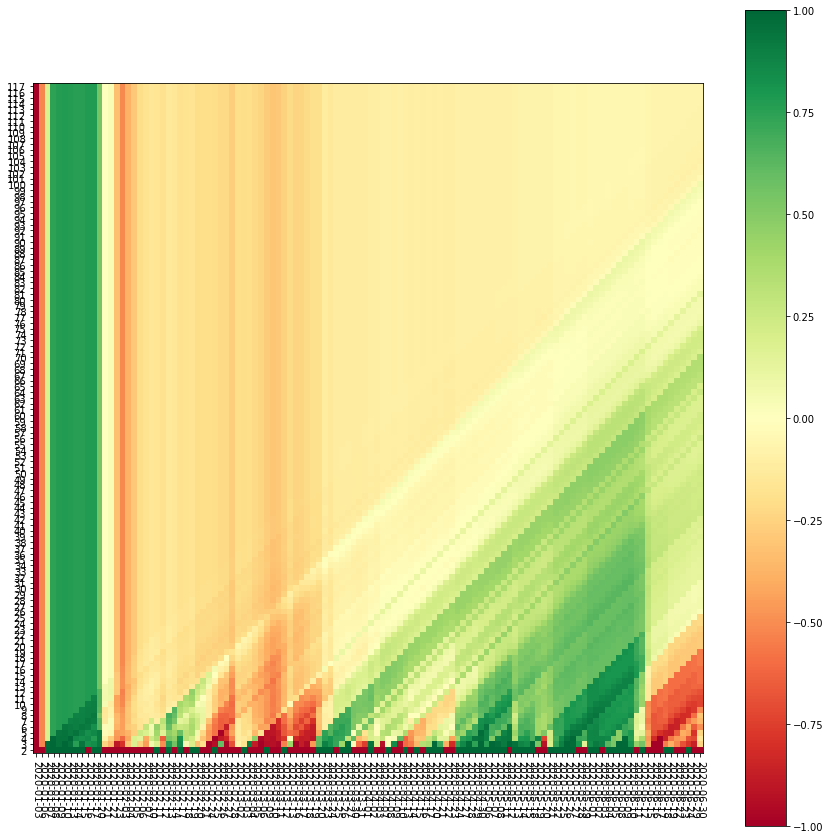

In [15]:
plot_corr(pinus, size=15)

pinus_output = {
    'date': pinus.columns.to_list(),
    'window': pinus.index.to_list(),
    'corr': [i for num, row in pinus.iterrows() for i in row.fillna(2).to_list()[-(len(pinus)+2-num):]]
}
# with open('../../client/src/components/pinus.json', 'w+') as file:
#     simplejson.dump(pinus_output, file, ignore_nan=True)

# pinus_output